In [1]:
## Cheat Method

In [1]:
from IPython.display import clear_output

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import gamma

# forcing nano scale
from matplotlib.ticker import ScalarFormatter
nano_formatter = ScalarFormatter(useMathText=True)
nano_formatter.set_powerlimits((-9, -9))  # Force e-9

# manually plotting prediction rings
from matplotlib.patches import Circle

# TrackPy stuff
import trackpy as tp
import pims

import cv2


# localization error 
sigma_loc = 100e-9

#returns pos_noisy of same shape with Gaussian noise.
def add_localization_error(pos, sigma):
    noise = np.random.normal(0, sigma, size=pos.shape)
    return pos + noise

def nano(num):
    return num * 10**(-9)

def stokes_einstein(r, t, T_Kelvin, eta):
    # Boltzmann's constant
    k_B = 1.38e-23

    # Calculate diffusion coefficient using Stokes-Einstein relation
    D = (k_B * T_Kelvin) / (6 * np.pi * eta * r)
    
    return D

In [3]:
# from test data
t = 0.1 #100 ms
T_Celsius = 23.4
T_Kelvin = T_Celsius + 273.15 #C to Kelvin
eta = 9.2e-4

num_particles = 100
num_frames = 100

# generate particle radiuses
radii = np.linspace(nano(50), nano(150), num_particles)
#radii = np.random.normal(nano(100), nano(10), num_particles)

# generate diffusion coefficients
Ds = stokes_einstein(radii, t, T_Kelvin, eta)
# calculate sigmas
variance = 2 * Ds * t
sigmas = np.sqrt(variance)

# create initial positions
positions = np.zeros((num_frames, num_particles, 2))
# have all particles start at origin for now

# do wiener step process
for frame in range(1, num_frames):
    # from previous group:
    move = np.column_stack((np.random.normal(0, sigmas, num_particles), 
                                 np.random.normal(0, sigmas, num_particles)))
    positions[frame] = positions[frame - 1] + move

#added noise to the positions
positions_noisy = add_localization_error(positions, sigma_loc)    

In [4]:
# localization error 
sigma_loc = 100e-9

#returns pos_noisy of same shape with Gaussian noise.
def add_localization_error(pos, sigma):
    noise = np.random.normal(0, sigma, size=pos.shape)
    return pos + noise

#added noise to the positions
positions_noisy = add_localization_error(positions, sigma_loc) 

Average σ_loc (nm): 151.07


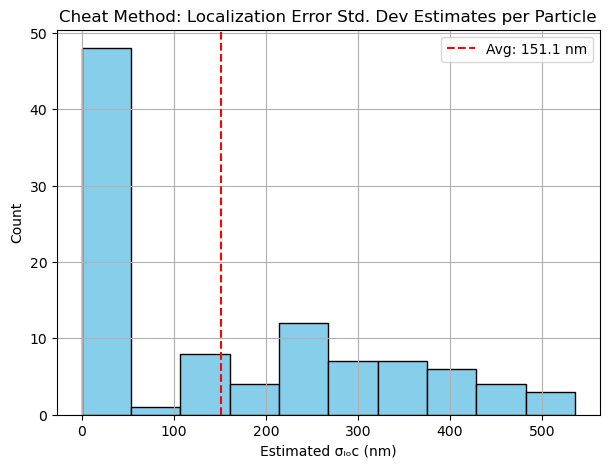

In [5]:
# Multi-Particle Cheat Method
import numpy as np
import matplotlib.pyplot as plt

# Physical constants
k_B = 1.38e-23                 # Boltzmann constant (J/K)
T_Kelvin = T_Celsius + 273.15   # Temperature in Kelvin
eta = 9.2e-4                   # Fluid viscosity (Pa·s)
delta_t = t                    # Frame interval (seconds)

# True particle radius (meters)
r_true = 100e-9  # 100 nm

# Expected diffusion coefficient
D_expected = (k_B * T_Kelvin) / (6 * np.pi * eta * r_true)
var_diffusion = 2 * D_expected * delta_t

# Cheat estimation of σ_loc per particle
num_particles = positions_noisy.shape[1]
sigma_loc_estimates = []

for index in range(num_particles):
    x_measured = positions_noisy[:, index, 0]
    y_measured = positions_noisy[:, index, 1]
    
    dx_measured = np.diff(x_measured)
    dy_measured = np.diff(y_measured)
    
    
    var_measured = np.var(np.concatenate((dx_measured, dy_measured)))
    var_localization = (var_measured - var_diffusion) / 2
    
    if var_localization < 0:
        sigma_loc = 0.0
    else:
        sigma_loc = np.sqrt(var_localization)
    
    sigma_loc_estimates.append(sigma_loc)

sigma_loc_estimates = np.array(sigma_loc_estimates)
avg_sigma_loc = np.mean(sigma_loc_estimates)

print(f"Average σ_loc (nm): {avg_sigma_loc * 1e9:.2f}")

# Plot σ_loc estimates
plt.figure(figsize=(7,5))
plt.hist(sigma_loc_estimates*1e9, bins=10, color='skyblue', edgecolor='black')
plt.axvline(avg_sigma_loc*1e9, color='red', linestyle='--', label=f'Avg: {avg_sigma_loc*1e9:.1f} nm')
plt.xlabel('Estimated σₗₒc (nm)')
plt.ylabel('Count')
plt.title('Cheat Method: Localization Error Std. Dev Estimates per Particle')
plt.legend()
plt.grid(True)
plt.savefig("cheat_method_plot1.jpg", dpi=400)
plt.show()

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

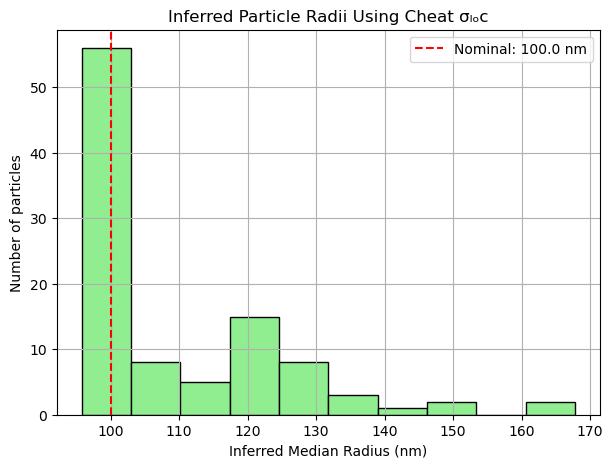

Average inferred radius: 109.58 nm
Std of inferred radii: 15.41 nm


In [6]:
# Per-particle MCMC Inference
import pymc as pm
import arviz as az

# Physical constant for radius conversion
C = (k_B * T_Kelvin * delta_t) / (3 * np.pi * eta)

radii_medians = []

for index in range(num_particles):
    clear_output()
    
    x_measured = positions_noisy[:, index, 0]
    y_measured = positions_noisy[:, index, 1]
    sigma_loc = sigma_loc_estimates[index]
    
    dx = np.diff(x_measured)
    dy = np.diff(y_measured)
    dist_arr = np.concatenate((dx, dy))
    
    with pm.Model() as model:
        sigma_phys = pm.HalfCauchy("sigma_phys", beta=5)
        sigma_eff  = pm.Deterministic(
            "sigma_eff", pm.math.sqrt(sigma_phys**2 + 2*sigma_loc**2)
        )
        tau = pm.Deterministic("tau", 1.0 / sigma_phys**2)
        
        obs = pm.Normal("obs", mu=0, sigma=sigma_eff, observed=dist_arr)
        
        trace = pm.sample(
        draws=20000,
        tune=10000,
        chains=4,
        target_accept=0.9,
        return_inferencedata=True,
        progressbar=True,
        nuts_sampler="numpyro"
    )
        
    tau_samples = trace.posterior["tau"].values.flatten()
    r_samples = tau_samples * C
    median_r = np.median(r_samples)
    radii_medians.append(median_r)

radii_medians = np.array(radii_medians)

# Plot inferred radii
plt.figure(figsize=(7,5))
plt.hist(radii_medians*1e9, bins=10, color='lightgreen', edgecolor='black')
plt.axvline(r_true*1e9, color='red', linestyle='--', label=f'Nominal: {r_true*1e9:.1f} nm')
plt.xlabel('Inferred Median Radius (nm)')
plt.ylabel('Number of particles')
plt.title('Inferred Particle Radii Using Cheat σₗₒc')
plt.legend()
plt.grid(True)
plt.show()

# Summary stats
print(f"Average inferred radius: {np.mean(radii_medians)*1e9:.2f} nm")
print(f"Std of inferred radii: {np.std(radii_medians)*1e9:.2f} nm")

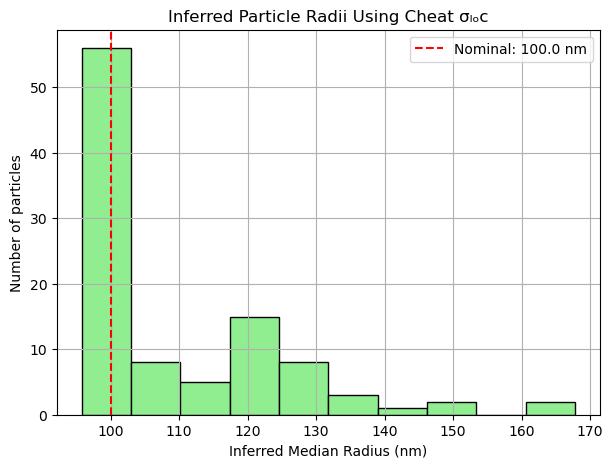

In [13]:
plt.figure(figsize=(7,5))
plt.hist(radii_medians*1e9, bins=10, color='lightgreen', edgecolor='black')
plt.axvline(r_true*1e9, color='red', linestyle='--', label=f'Nominal: {r_true*1e9:.1f} nm')
plt.xlabel('Inferred Median Radius (nm)')
plt.ylabel('Number of particles')
plt.title('Inferred Particle Radii Using Cheat σₗₒc')
plt.legend()
plt.grid(True)
plt.savefig("cheat_method_plot2.jpg", dpi=400)
plt.show()

Note:

- “Std dev of means” is the standard deviation of the posterior mean estimates across particles.\n"
- “Average posterior‐std” is the average of each particle’s own posterior‐distribution width."


σ_loc (nm): mean=213.65, var=55657.01, std=235.92


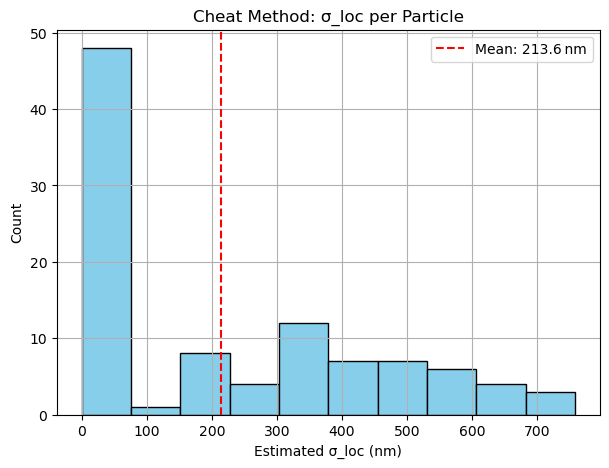

In [12]:
# Cheat Method (concatenate dx, dy)
import numpy as np
import matplotlib.pyplot as plt

k_B = 1.38e-23
T_Kelvin = T_Celsius + 273.15
eta = 9.2e-4
delta_t = t
r_true = 100e-9

# expected pure‐Brownian variance
D_expected = (k_B * T_Kelvin) / (6 * np.pi * eta * r_true)
var_diffusion = 2 * D_expected * delta_t

# estimate σ_loc per particle by pooling Δx and Δy
num_particles = positions_noisy.shape[1]
sigma_loc_estimates = []
for idx in range(num_particles):
    x = positions_noisy[:, idx, 0]
    y = positions_noisy[:, idx, 1]
    dx = np.diff(x)
    dy = np.diff(y)
    d_all = np.concatenate([dx, dy])
    var_measured = np.var(d_all, ddof=0)
    var_loc = var_measured - var_diffusion
    sigma_loc_estimates.append(np.sqrt(var_loc) if var_loc > 0 else 0.0)

sigma_loc_estimates = np.array(sigma_loc_estimates)

# summary statistics (in nm)
mean_sigma = np.mean(sigma_loc_estimates)
var_sigma  = np.var(sigma_loc_estimates)
std_sigma  = np.std(sigma_loc_estimates)
print(f"σ_loc (nm): mean={mean_sigma*1e9:.2f}, var={var_sigma*1e18:.2f}, std={std_sigma*1e9:.2f}")

# histogram
plt.figure(figsize=(7,5))
plt.hist(sigma_loc_estimates*1e9, bins=10, color='skyblue', edgecolor='black')
plt.axvline(mean_sigma*1e9, color='red', linestyle='--', label=f'Mean: {mean_sigma*1e9:.1f} nm')
plt.xlabel('Estimated σ_loc (nm)')
plt.ylabel('Count')
plt.title('Cheat Method: σ_loc per Particle')
plt.legend()
plt.savefig("cheat_method_plot3.jpg", dpi=400)
plt.grid(True)

plt.show()

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

Posterior means (nm):
  Mean of means:     110.38 nm
  Variance of means: 230.16 nm²
  Std dev of means:  15.17 nm

Average posterior‐std (within): 13.38 nm


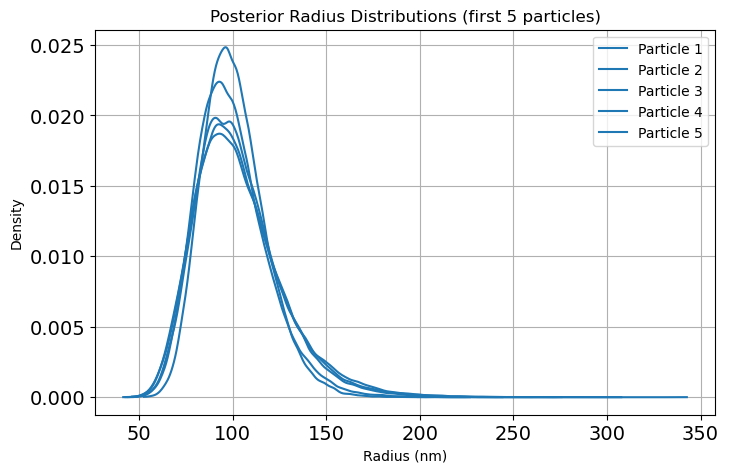

In [14]:
# Per‐particle MCMC & Posterior‐spread plot
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

C = (k_B * T_Kelvin * delta_t) / (3 * np.pi * eta)

posterior_radii = []
posterior_means  = []
posterior_stds   = []

for idx in range(num_particles):
    x = positions_noisy[:, idx, 0]
    y = positions_noisy[:, idx, 1]
    dx = np.diff(x)
    dy = np.diff(y)
    dist = np.concatenate((dx, dy))
    sigma_loc = sigma_loc_estimates[idx]
    
    with pm.Model() as model:
        sigma_phys = pm.HalfCauchy('sigma_phys', beta=5)
        sigma_eff  = pm.Deterministic('sigma_eff',
                                      pm.math.sqrt(sigma_phys**2 + sigma_loc**2))
        tau = pm.Deterministic('tau', 1.0 / sigma_phys**2)
        pm.Normal('obs', mu=0, sigma=sigma_eff, observed=dist)
        trace = pm.sample(
        draws=20000,
        tune=10000,
        chains=4,
        target_accept=0.9,
        return_inferencedata=True,
        progressbar=True,
        nuts_sampler="numpyro"
    )
    tau_samps = trace.posterior['tau'].values.flatten()
    r_samps   = tau_samps * C
    posterior_radii.append(r_samps)
    posterior_means.append(np.mean(r_samps))
    posterior_stds.append(np.std(r_samps))

posterior_means = np.array(posterior_means)
posterior_stds  = np.array(posterior_stds)

# Summary of posterior‐means (across particles)
print("Posterior means (nm):")
print(f"  Mean of means:     {posterior_means.mean()*1e9:.2f} nm")
print(f"  Variance of means: {posterior_means.var()*1e18:.2f} nm²")
print(f"  Std dev of means:  {posterior_means.std()*1e9:.2f} nm")

# Summary of within‐particle posterior widths
print(f"\nAverage posterior‐std (within): {posterior_stds.mean()*1e9:.2f} nm")

# KDE plot of first 5 posterior distributions
plt.figure(figsize=(8,5))
for i, r_samps in enumerate(posterior_radii[:5]):
    az.plot_kde(r_samps*1e9, label=f'Particle {i+1}')
plt.xlabel('Radius (nm)')
plt.ylabel('Density')
plt.title('Posterior Radius Distributions (first 5 particles)')
plt.legend()
plt.savefig("cheat_method_plot4.jpg", dpi=400)
plt.grid(True)
plt.show()